# **WINE COLOR PREDICTION**
In this project I will predict what color of wine it is based on its physicochemical properties.
The color of the wine can be either red or white since it will have a bigger contrast contributing
to better model accuracy.

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for converting arff to csv
!pip install liac-arff
import arff
import csv

# for one-hot encoding
from sklearn.preprocessing import LabelEncoder

# Data splitting
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# plots
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# to be checked
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

  Preparing metadata (setup.py) ... - done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=b259d2b776777b6d27445a15e7a10f3bd13fe7a9d784c31be0aa958e3ffcb99f
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


# Loading Datasets

In [2]:
wine_set_kaggle = pd.read_csv('/kaggle/input/wine-quality-data-set-red-white-wine/wine-quality-white-and-red.csv')
wine_set_kaggle.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Converting the second data set from arff to csv format.

In [3]:
with open('/kaggle/input/wine-set-openml/dataset_.arff', 'r') as arff_file:
    arff_data = arff.load(arff_file)

data = arff_data['data']
attributes = arff_data['attributes']

with open('wine_set_openml.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    writer.writerow([attr[0] for attr in attributes])
    writer.writerows(data)
    
wine_set_openml = pd.read_csv('wine_set_openml.csv')
wine_set_openml.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,style
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


# Data preparation

Ensuring that the columns are aligned and named consistently across both datasets.

In [4]:
last_column = wine_set_openml.pop('style')
wine_set_openml.insert(0, 'type', last_column)

wine_set_openml.columns = wine_set_openml.columns.str.replace('_', ' ')
wine_set_openml.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Data description to compare the values in both datasets.

In [5]:
wine_set_kaggle.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [6]:
wine_set_openml.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


How can both of them have same values???? huh ???? 🤔
They have the same shape and the same statistics.

# Merging the datasets

In [7]:
def are_equal_datasets(df1, df2):
    if df1.shape != df2.shape:
        return False
    df1_sorted = df1.sort_values(by=df1.columns.tolist()).reset_index(drop=True)
    df2_sorted = df2.sort_values(by=df2.columns.tolist()).reset_index(drop=True)
    return df1_sorted.equals(df2_sorted)

are_equal_datasets(wine_set_kaggle, wine_set_openml)

False

Because they have some distinct rows between them, we can merge one of the datasets with the distinct rows.

In [8]:
merged_diff = pd.merge(wine_set_kaggle, wine_set_openml, indicator=True, how='outer')
different_rows = merged_diff[merged_diff['_merge'] != 'both']
different_rows_from_second = different_rows[wine_set_openml.columns]

merged_set = pd.concat([wine_set_kaggle, different_rows_from_second], ignore_index=True)

#merging only the different rows where the wine is red
different_rows_red = merged_diff[(merged_diff['_merge'] != 'both') & (merged_diff['type'] == 'red')]
merged_red = pd.concat([wine_set_kaggle, different_rows_red], ignore_index=True)

# Adding IDs to the dataset

In [9]:
merged_set['id'] = merged_set.index + 1
merged_red['id'] = merged_red.index + 1

# Checking for null values

In [10]:
merged_set.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
id                      0
dtype: int64

In [11]:
merged_red.isna().sum()

type                       0
fixed acidity              0
volatile acidity           0
citric acid                0
residual sugar             0
chlorides                  0
free sulfur dioxide        0
total sulfur dioxide       0
density                    0
pH                         0
sulphates                  0
alcohol                    0
quality                    0
_merge                  6497
id                         0
dtype: int64

There aren't any null values which is great.

# Deleting unneeded columns

In my opinion quality score from the wine experts is not connected with the color of the wine.


In [12]:
wine_set_kaggle = wine_set_kaggle.drop(columns=['quality'])

In [13]:
merged_red = merged_red.drop(columns=['quality'])

# Data analysis

Using boxplot.

fixed acidity              Axes(0.125,0.712609;0.168478x0.167391)
volatile acidity        Axes(0.327174,0.712609;0.168478x0.167391)
citric acid             Axes(0.529348,0.712609;0.168478x0.167391)
residual sugar          Axes(0.731522,0.712609;0.168478x0.167391)
chlorides                  Axes(0.125,0.511739;0.168478x0.167391)
free sulfur dioxide     Axes(0.327174,0.511739;0.168478x0.167391)
total sulfur dioxide    Axes(0.529348,0.511739;0.168478x0.167391)
density                 Axes(0.731522,0.511739;0.168478x0.167391)
pH                          Axes(0.125,0.31087;0.168478x0.167391)
sulphates                Axes(0.327174,0.31087;0.168478x0.167391)
alcohol                  Axes(0.529348,0.31087;0.168478x0.167391)
quality                  Axes(0.731522,0.31087;0.168478x0.167391)
id                             Axes(0.125,0.11;0.168478x0.167391)
dtype: object

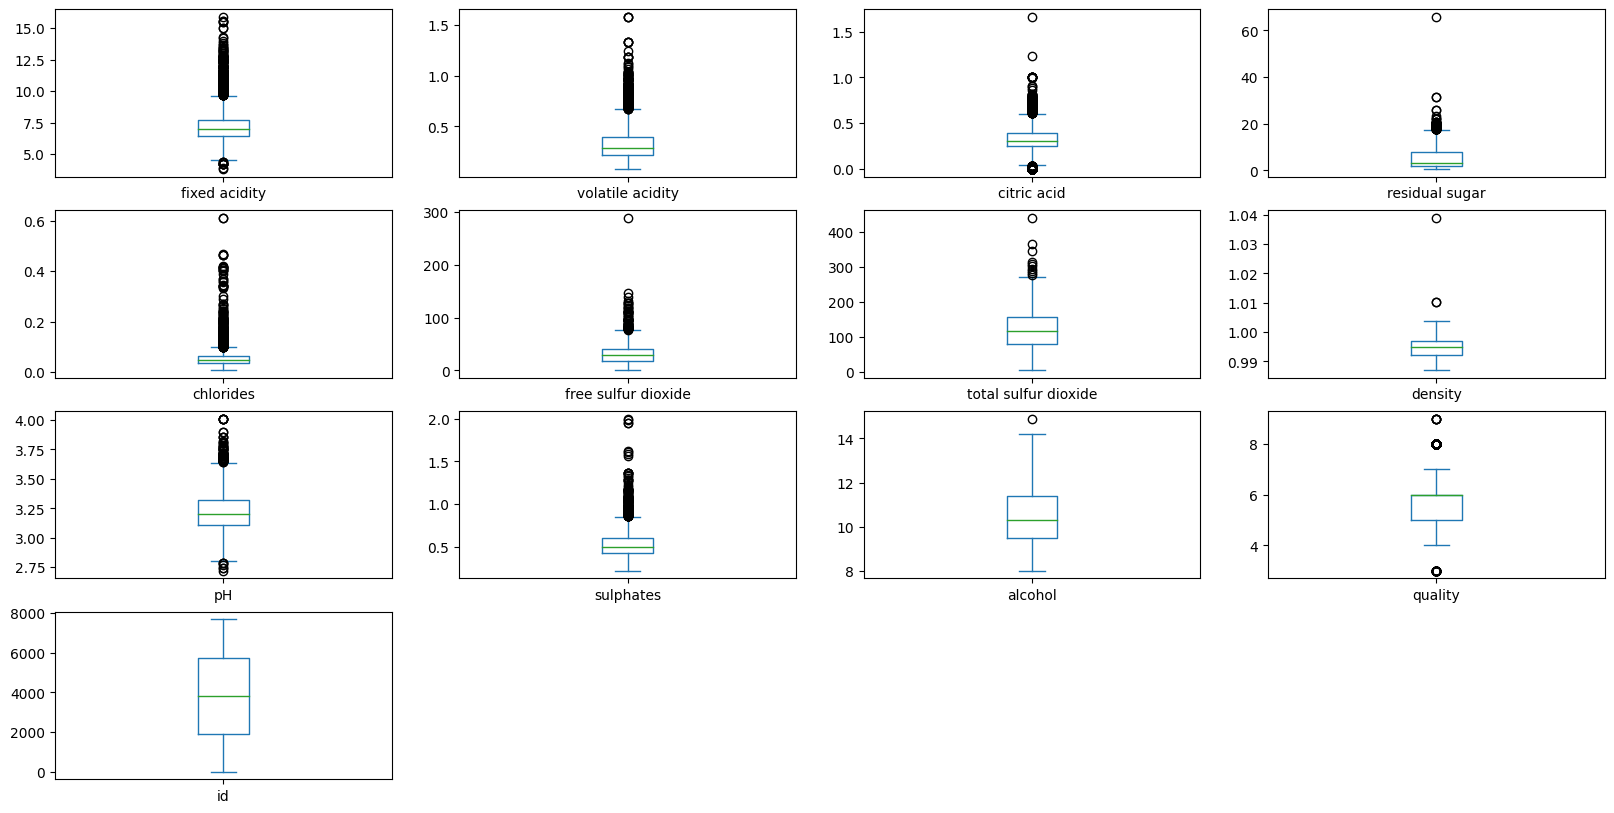

In [14]:
merged_set.plot(kind='box', subplots=True, layout=(4,4), sharex=False, figsize=(20, 10))

Creating histograms to see the distribution of the values.

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>,
        <Axes: title={'center': 'residual sugar'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>],
       [<Axes: title={'center': 'id'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

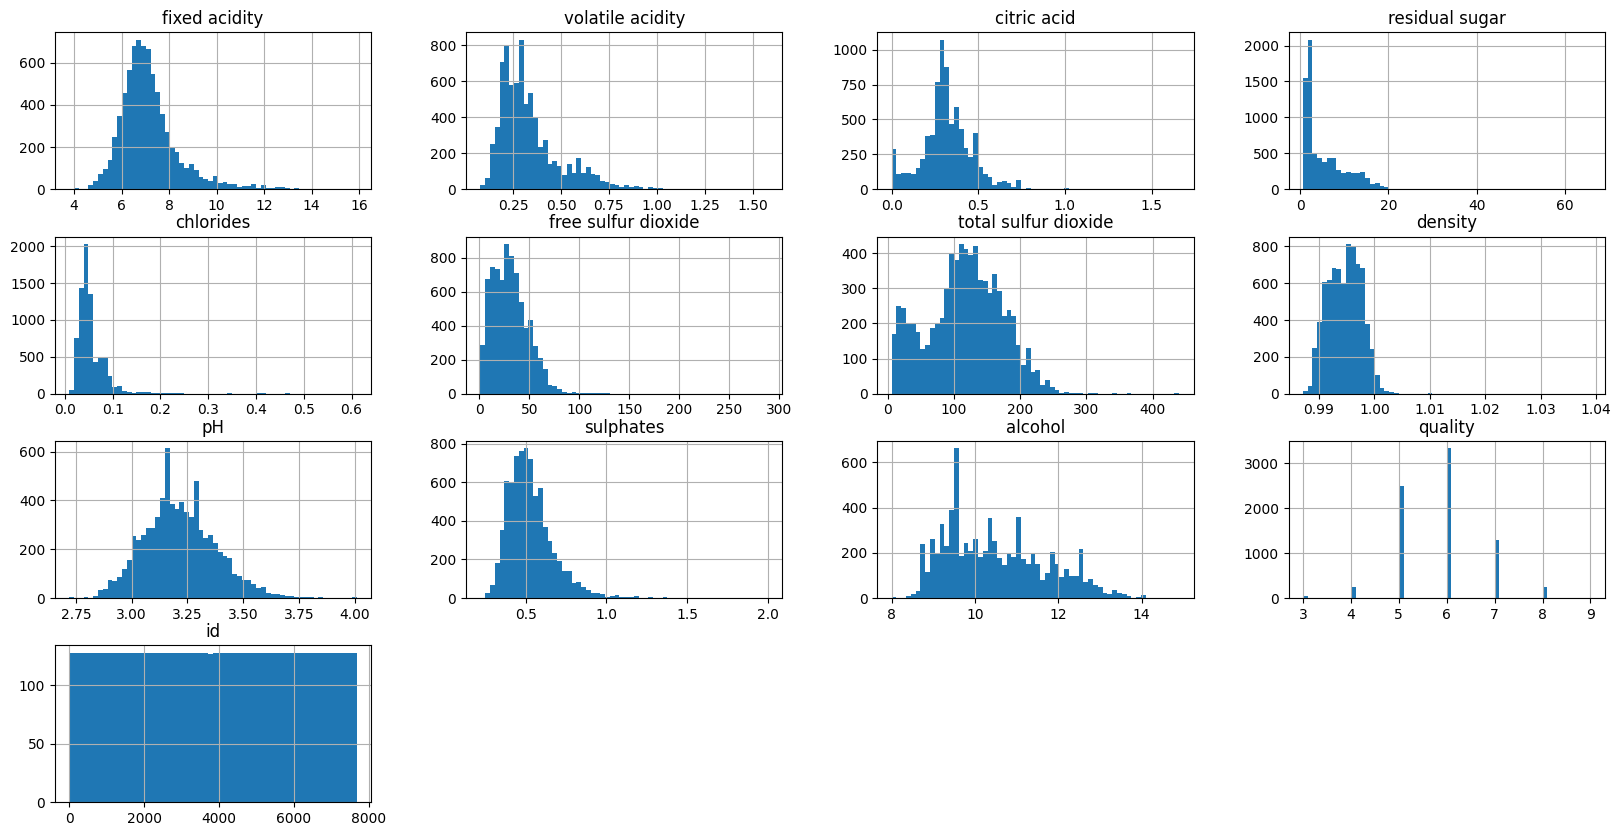

In [15]:
merged_set.hist(bins=60, figsize=(20, 10))

In the histograms we can see that some values go so far on the x axis, that means that there is at least one row with that value (probably ouliers).

# Dealing with outliers

I will check for the values that seem to have big difference between min and max.

The residual sugar has a big difference, according to goolge it should max around 19 g/l. But it also says that there are some white wines with even 60 g/l of residual sugar.
I will proceed to check which ones have more than 20 g/l of residual sugar.

In [16]:
merged_set[merged_set['residual sugar']>20]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,id
0,white,7.0,0.270,0.36,20.70,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,1
7,white,7.0,0.270,0.36,20.70,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,8
182,white,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,5,183
191,white,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,5,192
444,white,6.9,0.240,0.36,20.80,0.031,40.0,139.0,0.99750,3.20,0.33,11.0,6,445
1608,white,6.9,0.270,0.49,23.50,0.057,59.0,235.0,1.00240,2.98,0.47,8.6,5,1609
1653,white,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6,1654
1663,white,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6,1664
2620,white,6.5,0.280,0.28,20.40,0.041,40.0,144.0,1.00020,3.14,0.38,8.7,5,2621
2781,white,7.8,0.965,0.60,65.80,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6,2782


Scatter plots will easily show if there is some outlier.

<Axes: xlabel='id', ylabel='residual sugar'>

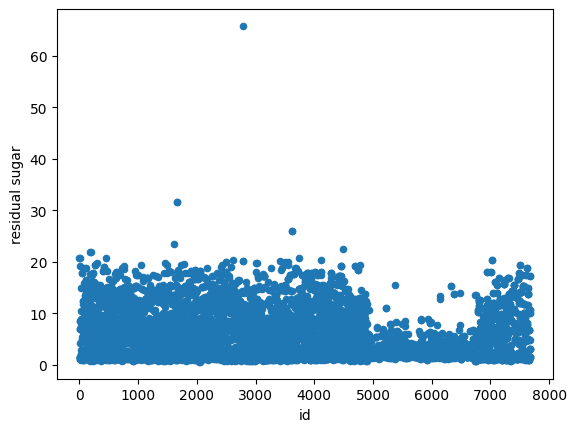

In [17]:
merged_set[['id','residual sugar']].plot(kind='scatter', x='id', y='residual sugar')

I decided to remove the wine with more than 60 g/l residual sugar because its value is double of the biggest before it.


In [18]:
merged_set = merged_set[merged_set['residual sugar']<=35.00]
merged_red = merged_red[merged_red['residual sugar'] <= 35.00]

In [19]:
merged_set[merged_set['free sulfur dioxide']>150]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,id
4745,white,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,4746


<Axes: xlabel='id', ylabel='free sulfur dioxide'>

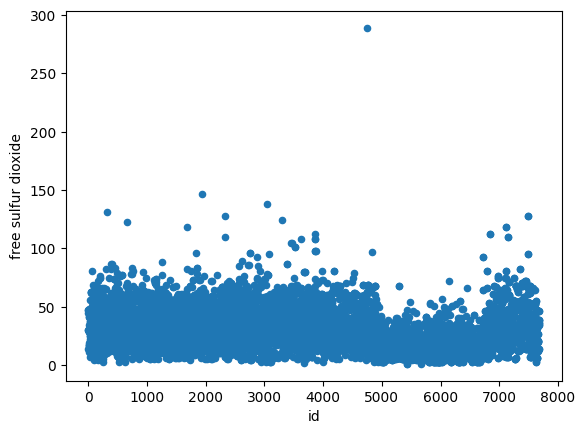

In [20]:
merged_set[['id','free sulfur dioxide']].plot(kind='scatter', x='id', y='free sulfur dioxide') 

I read that to have this much free SO2 in wine is possible, but I will delete it anyways, since the difference is very big

In [21]:
merged_set = merged_set[merged_set['free sulfur dioxide'] <= 150]
merged_red = merged_red[merged_red['free sulfur dioxide'] <= 150]

<Axes: xlabel='id', ylabel='citric acid'>

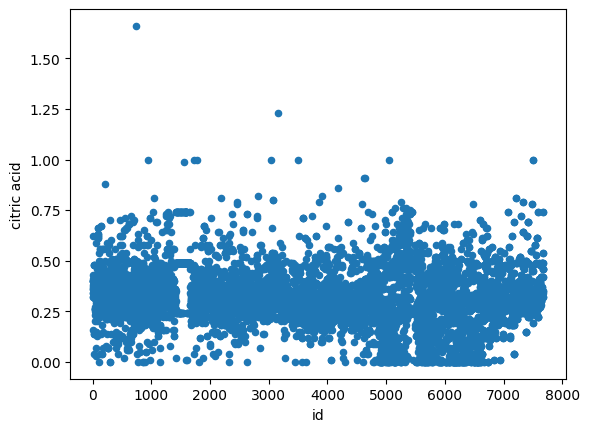

In [22]:
merged_set[['id','citric acid']].plot(kind='scatter', x='id', y='citric acid') 

<Axes: xlabel='id', ylabel='volatile acidity'>

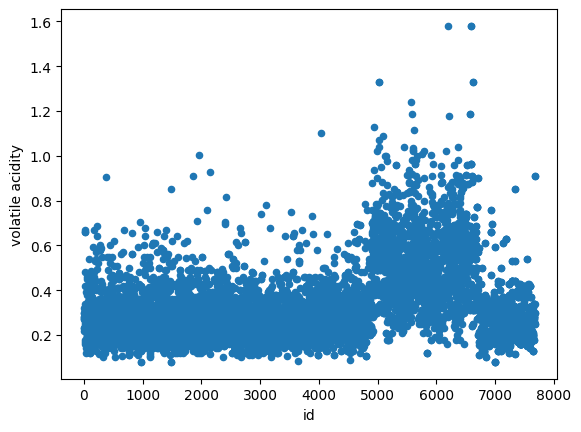

In [23]:
merged_set[['id','volatile acidity']].plot(kind='scatter', x='id', y='volatile acidity') 

<Axes: xlabel='id', ylabel='total sulfur dioxide'>

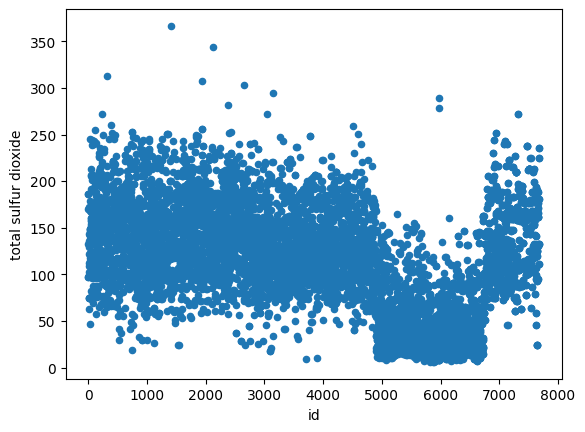

In [24]:
merged_set[['id','total sulfur dioxide']].plot(kind='scatter', x='id', y='total sulfur dioxide') 

In [25]:
merged_set[merged_set['total sulfur dioxide']>350] 

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,id
1417,white,8.6,0.55,0.35,15.55,0.057,35.5,366.5,1.0001,3.04,0.63,11.0,3,1418


The max legal limit of total SO2 is 350mg/l, but 366.6 is not that far, so I won't delete it.

<Axes: xlabel='id', ylabel='sulphates'>

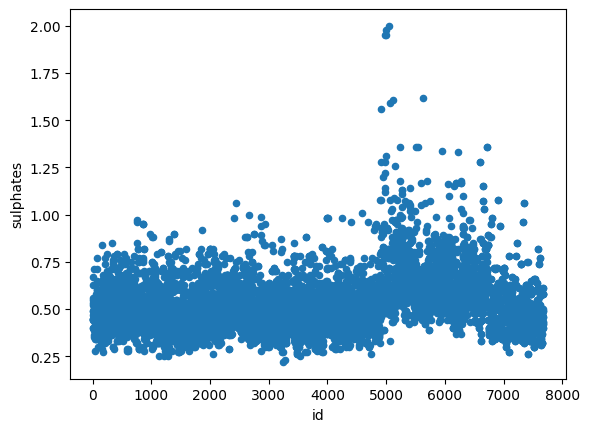

In [26]:
merged_set[['id','sulphates']].plot(kind='scatter', x='id', y='sulphates') 

# Balancing the data

In [27]:
merged_set['type'].value_counts()

type
white    5850
red      1827
Name: count, dtype: int64

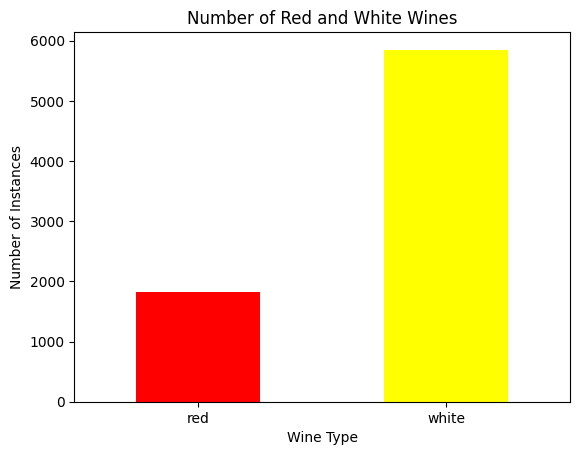

In [28]:
wine_counts = merged_set.groupby('type')['id'].count()

wine_counts.plot(kind='bar', color=['red', 'yellow'])
plt.xlabel('Wine Type')
plt.ylabel('Number of Instances')
plt.title('Number of Red and White Wines')
plt.xticks(rotation=0) 
plt.show()


**Decided to remove some of the white wines**

In [29]:
# additional_white_samples = wine_set_kaggle[wine_set_kaggle['type'] == 'red'].sample(n=1000, replace=True)
# wine_set_kaggle = pd.concat([wine_set_kaggle, additional_white_samples])

remove_indices = merged_set[merged_set['type'] == 'white'].sample(frac=0.7).index
merged_set = merged_set.drop(remove_indices)

merged_set['type'].value_counts()

type
red      1827
white    1755
Name: count, dtype: int64

In [30]:
remove_indices = merged_red[merged_red['type'] == 'white'].sample(frac=0.65).index
merged_red = merged_red.drop(remove_indices)

merged_red['type'].value_counts()

type
red      1827
white    1714
Name: count, dtype: int64

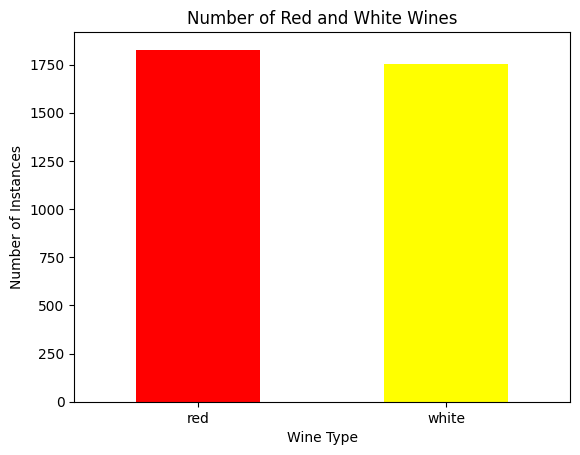

In [31]:
wine_counts = merged_set.groupby('type')['id'].count()

wine_counts.plot(kind='bar', color=['red', 'yellow'])
plt.xlabel('Wine Type')
plt.ylabel('Number of Instances')
plt.title('Number of Red and White Wines')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

# Splitting dataset
 And one-hot encoding

In [32]:
X = merged_set.drop(columns=['type', 'id'])
y = merged_set['type'] 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

y = 1 - y

#just to check if there realy are just 2 values
"Unique values in y:", np.unique(y)


('Unique values in y:', array([0, 1]))

DecisionTreeClassifier(random_state=42)
Accuracy: 0.977 (0.009)


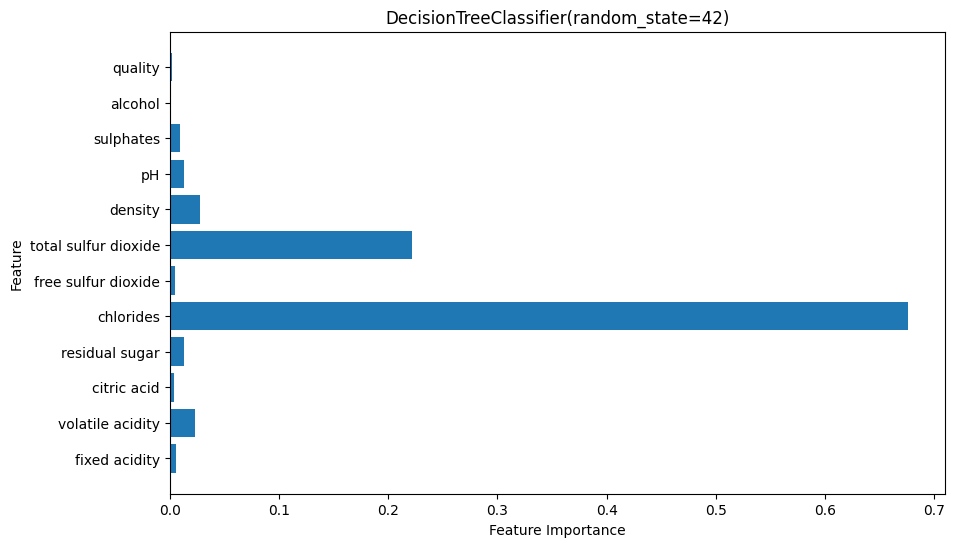

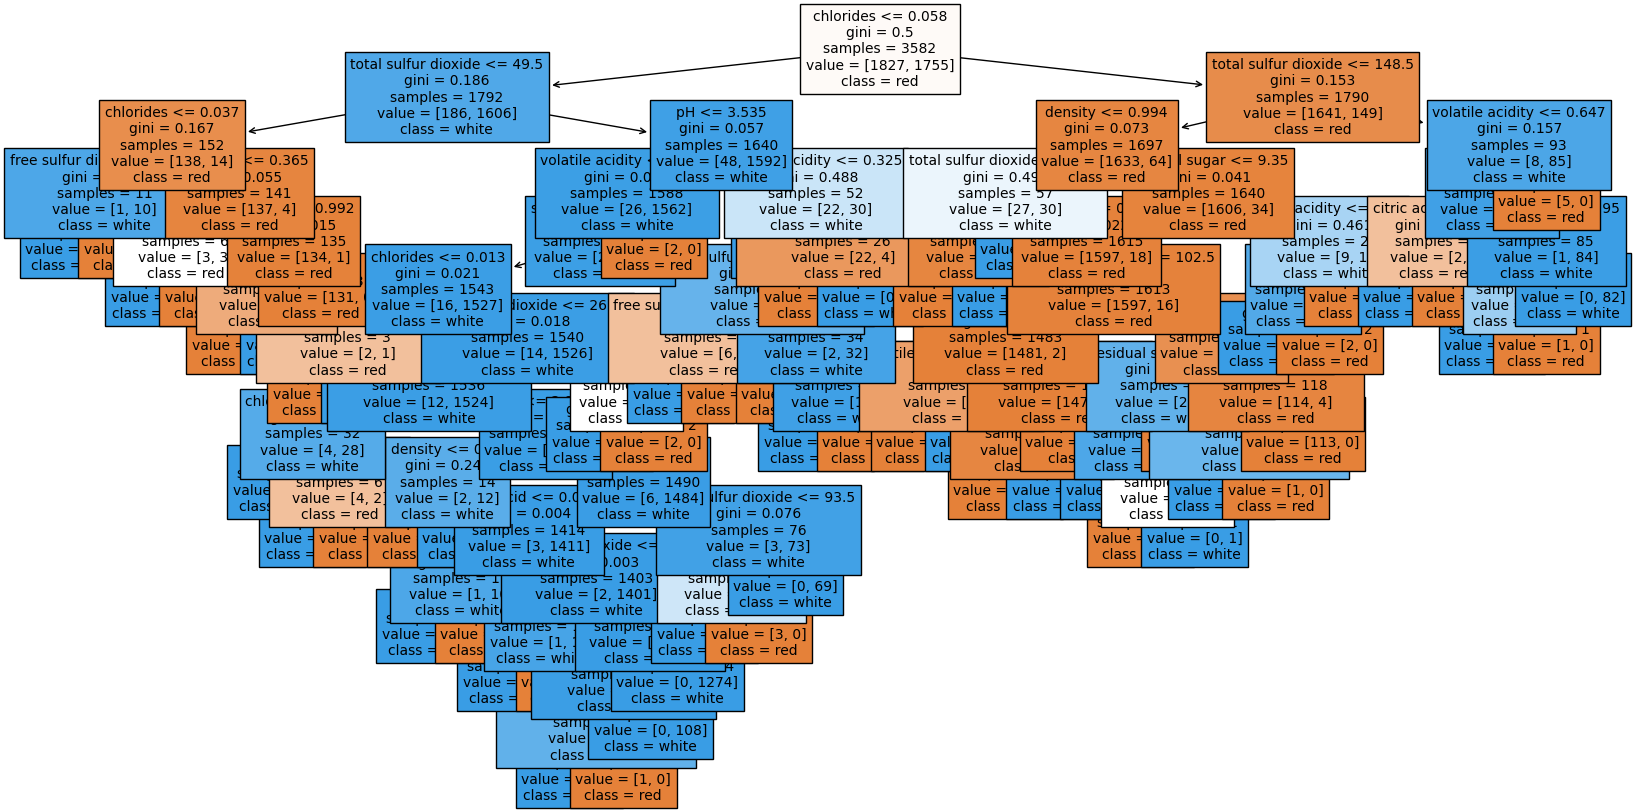

RandomForestClassifier(random_state=42)
Accuracy: 0.993 (0.004)


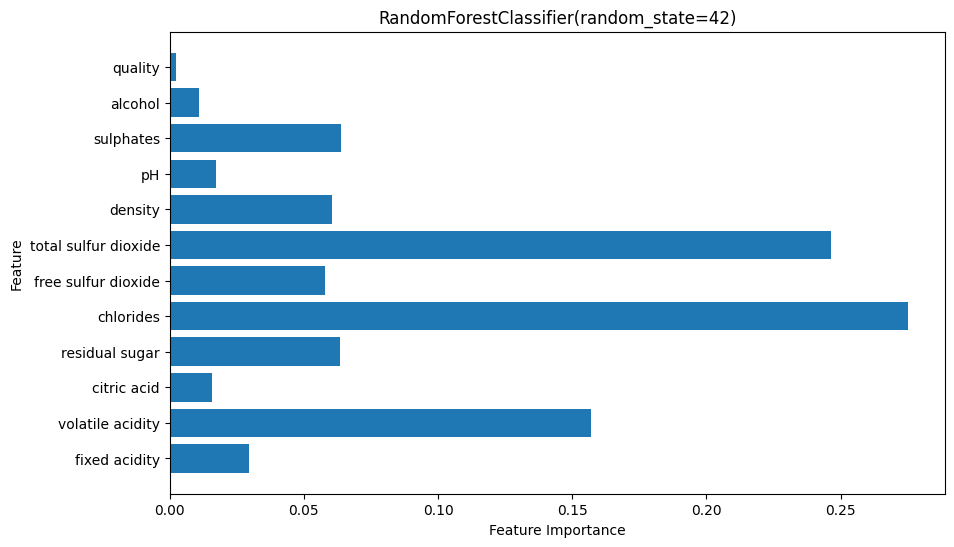

KNeighborsClassifier(n_neighbors=3)
Accuracy: 0.924 (0.015)
HistGradientBoostingClassifier(random_state=42)
Accuracy: 0.995 (0.003)


In [33]:
X = merged_set.drop(columns=['type', 'id'])
y = merged_set['type'] 
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
models = [ DecisionTreeClassifier(random_state=42), 
           RandomForestClassifier(n_estimators=100, random_state=42),
#            LogisticRegression(),
           KNeighborsClassifier(n_neighbors=3),
           HistGradientBoostingClassifier(random_state=42)]
# ja namalva snsata modelot da overfitni, deka gi izbira na random
for model in models:
    print(model)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    model.fit(X, y)
    if (isinstance(model,RandomForestClassifier) or isinstance(model,DecisionTreeClassifier)):
        
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(model.feature_importances_)), model.feature_importances_)
        plt.yticks(range(len(X.columns)), X.columns)
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title(model)
        plt.show()
    
    if isinstance(model,DecisionTreeClassifier):
        plt.figure(figsize=(20, 10))
        plot_tree(model, filled=True, feature_names=X.columns, class_names=['red', 'white'], fontsize=10)
        plt.show()
        



# Decision tree classifier

Accuracy: 0.9832635983263598


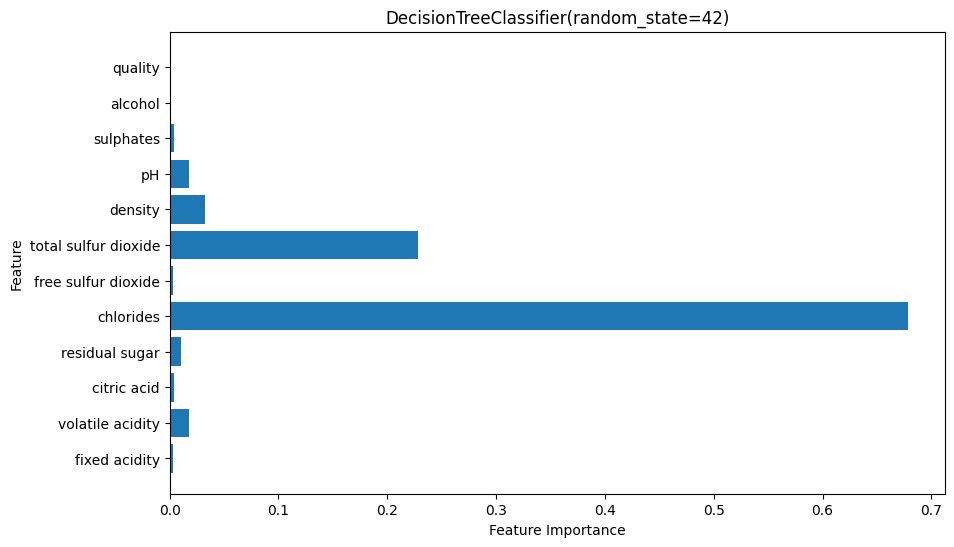

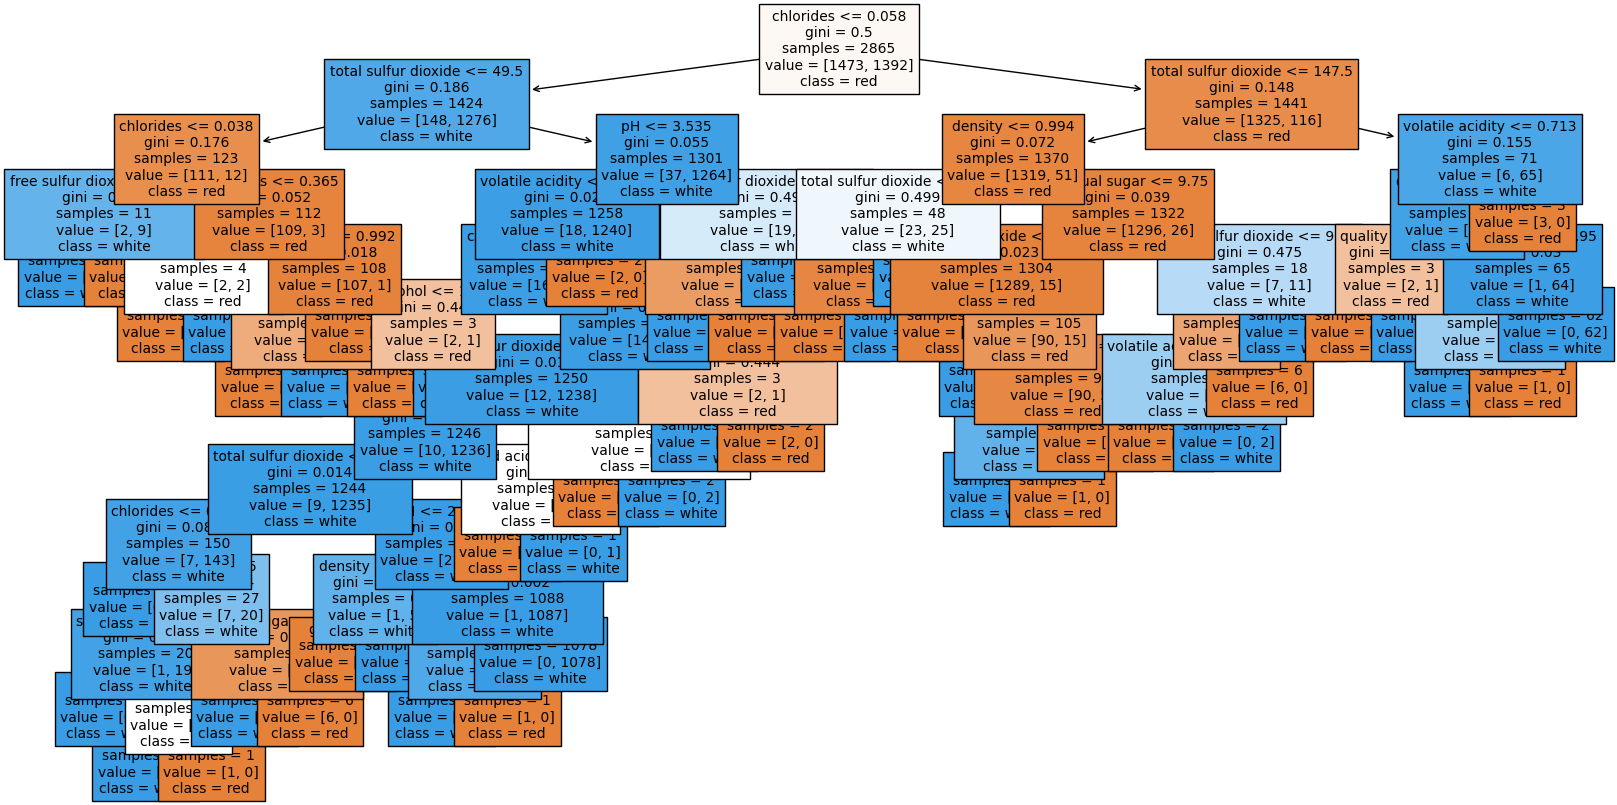

              precision    recall  f1-score   support

         red       0.99      0.98      0.98       354
       white       0.98      0.99      0.98       363

    accuracy                           0.98       717
   macro avg       0.98      0.98      0.98       717
weighted avg       0.98      0.98      0.98       717

[[346   8]
 [  4 359]]


In [34]:


# Assuming 'X' contains the features and 'y' contains the target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

plt.figure(figsize=(10, 6))
plt.barh(range(len(dt_classifier.feature_importances_)), dt_classifier.feature_importances_)
plt.yticks(range(len(X.columns)), X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(dt_classifier)
plt.show()

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, filled=True, feature_names=X.columns, class_names=['red', 'white'], fontsize=10)
plt.show()

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

# Random Forest Classifier

Random Forest Accuracy: 0.99302649930265


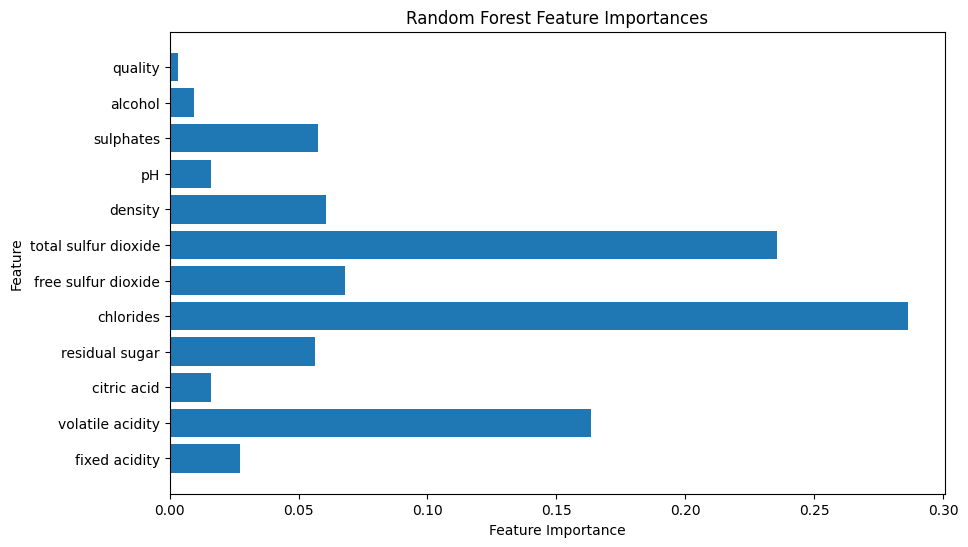

              precision    recall  f1-score   support

         red       0.99      0.98      0.98       354
       white       0.98      0.99      0.98       363

    accuracy                           0.98       717
   macro avg       0.98      0.98      0.98       717
weighted avg       0.98      0.98      0.98       717

[[346   8]
 [  4 359]]


In [35]:

# Create and train the Random Forest classifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

# Plot the most important features
plt.figure(figsize=(10, 6))
plt.barh(range(len(rf_classifier.feature_importances_)), rf_classifier.feature_importances_)
plt.yticks(range(len(X.columns)), X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.show()

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

In [36]:
# Create and train the decision tree classifier
hgb_classifier = HistGradientBoostingClassifier(random_state=42)
hgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = hgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Accuracy: 0.99581589958159
              precision    recall  f1-score   support

         red       1.00      0.99      1.00       354
       white       0.99      1.00      1.00       363

    accuracy                           1.00       717
   macro avg       1.00      1.00      1.00       717
weighted avg       1.00      1.00      1.00       717

[[351   3]
 [  0 363]]


In [37]:
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# knn_model = KNeighborsClassifier(n_neighbors=3)
# scores = cross_val_score(knn_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
# print(knn_model)
# knn_model.fit(X_train, y_train)
# print(X_pca,X_test,X_train, y_train)

# plt.figure(figsize=(10, 6))
# plt.plot(X_train+X_test,X_pca,cmap='viridis', edgecolor='k', s=50)
# # plt.plot(y_test,knn_model.predict(X_test),kind='kde')
# plt.xlabel('y')
# plt.ylabel('pred')
# plt.title('KNN Classifier')
# plt.show()